# The heterogenous causal effect of economic integration agreements on Foreign Direct Investment (FDI)

In this file we estimate the causal effects of economic integration agreements on investment flows:

We can study only one discrete treatment, or many continuous treatments.
In addition, the dependent variable needs to be continuous? Not sure about this, probably yes. Otherwise we would have a linear probability model

* A dummy indicator for the presence of a BIT
* A dummy indicator for the presence of a PTA
* A discrete indicator for the depth of a PTA

Can study heterogeneity as well, relative to some variable
* GDP per capita, as proxy for economic development

Different estimators will be considered

The data we have is a panel, therefore need to add fix effects

We study FDI in two dimensions
* Extensive: creation of new bilateral FDI relations
* Intensive: increase of already positive bilateral FDI stocks

For each of them, we employ linear and parametric estimation. Heterogenous effects are studied by taking into account the level of economic development by the source and the destination, proxied by GDP per capita.


Useful links:
* https://econml.azurewebsites.net/reference.html
* https://econml.azurewebsites.net/spec/estimation.html



In [72]:
import econml
import os
import numpy as np
import pandas as pd

## Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Main imports
from econml.dml import LinearDML, CausalForestDML
from econml.dr import LinearDRLearner, ForestDRLearner

# Helper imports
from itertools import product
from sklearn.linear_model import (Lasso, LassoCV, LogisticRegression,
                                  LogisticRegressionCV,LinearRegression,
                                  MultiTaskElasticNet,MultiTaskElasticNetCV)
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
import matplotlib.pyplot as plt
import matplotlib
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
os.chdir('C:/Users/desil/Documents/GitHub/EconML')

## Import data

In [3]:
# read in data
d = pd.read_csv('data/CAS_fdi_panel_complete.csv', sep=',')
d.shape

In [4]:
d.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268213 entries, 0 to 268212
Data columns (total 48 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   ID_dir             268213 non-null  object 
 1   year               268213 non-null  int64  
 2   stock              268213 non-null  float64
 3   th_o               268213 non-null  int64  
 4   th_d               268213 non-null  int64  
 5   bit                268213 non-null  int64  
 6   desta_pta          268213 non-null  int64  
 7   desta_depth        268213 non-null  int64  
 8   desta_full_fta     268213 non-null  int64  
 9   desta_iprs         268213 non-null  int64  
 10  desta_procurement  268213 non-null  int64  
 11  desta_standards    268213 non-null  int64  
 12  desta_services     268213 non-null  int64  
 13  desta_investments  268213 non-null  int64  
 14  desta_competition  268213 non-null  int64  
 15  contig             268213 non-null  int64  
 16  di

## Prepare data 

Ideally should use all of the years, but when computing the fixed effects (FE), the dimension increases by a lot and we run into RAM issues. There are approximately 25000 unique country pairs, and therefore the matrix of FE has dimenstion 268000 x 25000. For the time being, reduce the years coverage of the data. 

In [5]:
# count observations by year
d.groupby(['year']).size()

year
2002     9956
2003    10098
2004    10208
2005    13504
2006    14074
2007    13980
2008    13826
2009    17575
2010    18625
2011    19995
2012    20242
2013    17682
2014    16727
2015    16763
2016    17074
2017    18953
2018    18931
dtype: int64

In [6]:
# subset data according to year
d = d[d["year"] > 2016]

The outcome of interest is the stock of FDI from source in the destination country. When studying the intensive margin we only consider FDI values that are positive and take the log. Alternatively, use a log trans that preserves the zeros.

(array([26711.,  2179.,  2272.,  2123.,  1909.,  1267.,   835.,   402.,
          139.,    47.]),
 array([ 0.        ,  1.39101826,  2.78203652,  4.17305477,  5.56407303,
         6.95509129,  8.34610955,  9.73712781, 11.12814606, 12.51916432,
        13.91018258]),
 <a list of 10 Patch objects>)

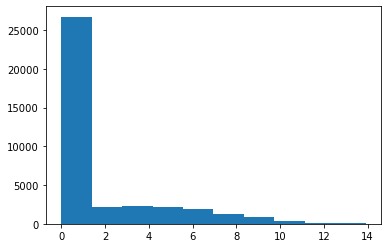

In [8]:
#d['stock'] = np.where(d['stock']>0, 1, 0)
#d.groupby(['stock']).size()

y = np.log1p(d['stock'].values) 
plt.hist(y)



We can study different types of treatment variables:

* Binary indicators for the presence of a Bilateral Investment Agreement and a Preferential Trade Agreement
* A numeric variable for the depth of a Preferential Trade Agreement
* A set of binary variables for the different component of Preferential Trade Agreements

In [18]:
# A binary treatment for the presence of a bit
t_var = ["bit"]
t = d[t_var].values.reshape(-1,1) 

print(t.shape)

[[0]
 [0]
 [0]
 ...
 [0]
 [1]
 [0]]
(37884, 1)


Select the variables that we want to use in the estimation of the heterogeneous effects

In [11]:
# variable for the heterogeneous effects
hetero_vars = ["gdpcap_o", "gdpcap_d"]
X = d[hetero_vars].values


Control variables are socio-economic factors associated with both the probability of receiving the different treatment, and the outcome variables. In addition, we also have to compute the fixed effects, in order to take in accout the panel nature of the data.

In [12]:
# matrix with controls
policy_vars = [ #"desta_pta",
                "desta_full_fta",
                "desta_iprs",
                "desta_procurement",
                "desta_standards",
                "desta_services",
                "desta_investments",
                "desta_competition"]



control_drops = hetero_vars + policy_vars + t_var + ['ID_dir'] + ['year'] + ['stock']
W = d.drop(control_drops, axis=1).values


In [13]:
# Create Fixed effects
from sklearn.preprocessing import OneHotEncoder

FE = OneHotEncoder(sparse=False).fit_transform(d['ID_dir'].values.reshape(-1, 1))


In [14]:
# we drop one in order to avoid multicollinearity
#W = np.append(W, FE[:, 1:], axis=1)

In [15]:
W.shape

In [16]:
print(type(y))
print(type(t))
print(type(X))
print(type(W))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [20]:
print(y.shape)
print(t.shape)
print(X.shape)
print(W.shape)

(37884,)
(37884, 1)
(37884, 2)
(37884, 35)


Finally, we also need to prepare the vectors for analyzing the heterogenous effects

In [44]:
# gdpcap_o
x_0 = np.array(np.linspace(np.min(X[:,0 ]),
                           np.max(X[:,0 ]),
                           15)).reshape(-1,1)

In [45]:
# gdpcap_d
x_1 = np.array(np.linspace(np.min(X[:,1 ]),
                           np.max(X[:,1 ]),
                           15)).reshape(-1,1)

In [46]:
# now need to get all the combinations
X_test = np.array([(x, y) for x in x_0 for y in x_1])[:,:,0]
X_test.shape

In addition, we also create some test data by keeping the one of the axis constant

In [24]:
# first need to come up with the test data
X_test_1 = np.array([(x, y) for x in x_0 for y in x_1[np.argmax(x_1>np.median(x_1))]]) #[:,:,0]
X_test_0 = np.array([(x, y) for x in x_0[np.argmax(x_0>np.median(x_0))] for y in x_1]) # [:,:,0]

print(X_test_0.shape)
print(X_test_1.shape)

(50, 2)
(50, 2)


## Double Machine Learning

Double machine learning estimation techniques consits in three steps:
* predict the outcome from the controls
* predict the treatment from the controls
* use the results from the previous steps to create a model of heterogenous causal effects

The models used in the predictive task need to be adequate for the type of treatment and the type of outcome. Different methods can be used for the third step. We compare estimates from a standard linear model to estimates obtained with a causal random forest model.

## Model 1: Parametric estimation, double machine learning (LinearDML)

The baseline model we consider is an unregularized final model, which return confidence intervals for the effects, either using the standard asymptotic theory, or by bootstrapping:

https://econml.azurewebsites.net/_autosummary/econml.dml.LinearDML.html#econml.dml.LinearDML

https://github.com/microsoft/EconML/blob/master/notebooks/Double%20Machine%20Learning%20Examples.ipynb

Notes:


* **cv** is the number of folds for cross validation, uses StratifiedKFold when treatment is discrete. Defaults is 2
* by default, will apply **LogisticRegressionCV** when **discrete_treatment=True**
* with **fit_cate_intercept = True** the model estimates an intercept ( effect when hetero vars==0)
* could pass in a function to **featurizer = None** to get polynomials of the hetero variables 


In [97]:
# firstly we define the model

est1 = LinearDML(model_y=RandomForestRegressor(),
                model_t=RandomForestClassifier(min_samples_leaf=10),
                discrete_treatment=True,
                fit_cate_intercept = True,
                featurizer = None,
                linear_first_stages=True,
                cv=6)


In [98]:
# estimate the model
est1.fit(y,
        t,
        X=X,
        W=W)

## Model 2: Non parametric estimation, double machine learning (CausalForestDML)

https://econml.azurewebsites.net/_autosummary/econml.dml.CausalForestDML.html#econml.dml.CausalForestDML

Hyperparameters:

 *   **cv** is the number of folds for cross validation, uses StratifiedKFold when treatment is discrete. Defaults is 2
 *   with **fit_cate_intercept = True** the model estimates an intercept ( effect when hetero vars==0)
 *   could pass in a function to **featurizer = None** to get polynomials of the hetero variables




In [121]:
est2 = CausalForestDML(model_y=RandomForestRegressor(),
                       model_t=RandomForestClassifier(min_samples_leaf=10),
                       discrete_treatment=True,
                       n_estimators=2000, # 1000
                       min_samples_leaf=10,
                       min_impurity_decrease=0.001,
                       verbose=0,
                       cv=6)

In [ ]:
est2.tune(y,
          t,
          X=X,
          W=W)

est2.fit(y,
         t,
         X=X,
         W=W)

## Doubly robust learning

Doubly robust machine learning estimation techniques consits in three steps:
* predict the outcome from the controls **and the treatment**
* predict the treatment from the controls
* use the results from the previous steps to create a model of heterogenous causal effects

The models used in the predictive task need to be adequate for the type of treatment and the type of outcome. Different methods can be used for the third step. We compare estimates from a standard linear model to estimates obtained with a causal random forest model.

## Model 3: Parametric estimation, doubly robust learning (LinearDRLearner)

https://econml.azurewebsites.net/_autosummary/econml.dr.LinearDRLearner.html#econml.dr.LinearDRLearner

Notes:

* **model_propensity** is the model used to estimate the probability of receiving treatment. The default is ** LogisticRegressionCV**. We will use a random forest classifier instead.

* **model_regression** is the second step, trained by regressing y on the treatment variables, variables used for the heterogenous effects, and controls. We will use RandomForestRegressor()


In [75]:

est3 = LinearDRLearner( model_propensity=RandomForestClassifier(min_samples_leaf=10),
                        model_regression=RandomForestRegressor(),
                        fit_cate_intercept = True,
                        featurizer = None,
                        cv=6)

In [76]:
est3.fit(y,
         t,
         X=X,
         W=W)

## Model 4: Non parametric estimation, doubly robust learning (ForestDRLearner)

https://econml.azurewebsites.net/_autosummary/econml.dr.ForestDRLearner.html#econml.dr.ForestDRLearner

In [81]:
est4 = ForestDRLearner(model_regression=RandomForestRegressor(),
                       model_propensity=RandomForestClassifier(min_samples_leaf=10),
                       cv=3,
                       n_estimators=2000,
                       min_samples_leaf=10,
                       verbose=0,
                       min_weight_fraction_leaf=.005)

In [82]:
est4.fit(y,
         t,
         X=X,
         W=W)

## Comparisons of results

In this section we compare the results of the 4 models.

* From each model we can calculate a heatmap, showing the predicted causal effects of having a BIT in place, conditional on GDP per capita levels of both origin and destination

* Double robust models: we can compere the estimates for the

### Summary of model 1

Model 1 estimates linear effects, therefore there will be an intercept showing the effect of the treatment when the heterogenous variables are both zero, and two coefficients for the heterogeneous variables:

In [ ]:
est0.summary()

### Summary of model 2

In [95]:
est3.summary(T=1)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-19.373,19.476,-0.995,0.32,-51.407,12.662
X1,-27.404,27.338,-1.002,0.316,-72.371,17.563
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,38.875,38.435,1.011,0.312,-24.345,102.096


In [96]:
est4.summary(T=1)

AttributeError: 'ForestDRLearner' object has no attribute 'summary'

In [79]:
est3.summary(T=0)

Coefficient Results:  No model was fitted for the control
CATE Intercept Results:  No model was fitted for the control


### Predicted causal effecs

In [105]:
# Model 1
tau_1 = est1.effect(X_test)
lb_1, ub_1 = est1.effect_interval(X_test, alpha=0.01)

In [106]:
# Model 2
tau_2 = est2.effect(X_test)
lb_2, ub_2 = est2.effect_interval(X_test, alpha=0.01)

In [107]:
# Model 3
tau_3 = est3.effect(X_test)
lb_3, ub_3 = est3.effect_interval(X_test, alpha=0.01)

In [108]:
# Model 4
tau_4 = est4.effect(X_test)
lb_4, ub_4 = est4.effect_interval(X_test, alpha=0.01)

## Heatmaps with effects

### Model 1 heatmap

In [112]:
df1 = pd.DataFrame.from_dict(np.array([np.around(X_test[:, 0], decimals=2, out=None),
                                          np.around(X_test[:, 1], decimals=2, out=None),
                                          tau_1]).T)

df1.columns = ['X_value','Y_value','Z_value']

df1['Z_value'] = pd.to_numeric(df1['Z_value'])

In [113]:
df1 = df1.pivot('Y_value','X_value','Z_value')

In [114]:
df1.sort_index(level=0, ascending=False, inplace=True)

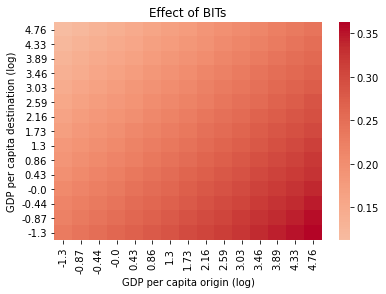

In [116]:
import seaborn as sns
sns.heatmap(df1,
            cmap='coolwarm',
            center=0)

# Add title and labels to plot.
plt.title('Model 1')
plt.xlabel('GDP per capita origin (log)')
plt.ylabel('GDP per capita destination (log)')
plt.savefig("charts/heatmap_model_1.png")

### Model 2 heatmap

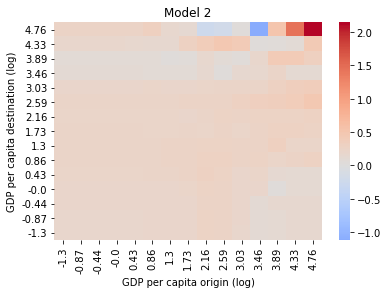

In [118]:
df2 = pd.DataFrame.from_dict(np.array([np.around(X_test[:, 0], decimals=2, out=None),
                                          np.around(X_test[:, 1], decimals=2, out=None),
                                          tau_2]).T)

df2.columns = ['X_value','Y_value','Z_value']

df2['Z_value'] = pd.to_numeric(df2['Z_value'])

df2 = df2.pivot('Y_value','X_value','Z_value')

df2.sort_index(level=0, ascending=False, inplace=True)

sns.heatmap(df2,
            cmap='coolwarm',
            center=0)

# Add title and labels to plot.
plt.title('Model 2')
plt.xlabel('GDP per capita origin (log)')
plt.ylabel('GDP per capita destination (log)')
plt.savefig("charts/heatmap_model_2.png")

### Model 3 heatmap

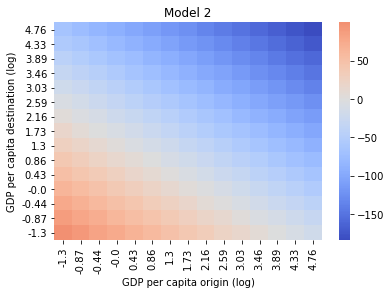

In [119]:
df3 = pd.DataFrame.from_dict(np.array([np.around(X_test[:, 0], decimals=2, out=None),
                                          np.around(X_test[:, 1], decimals=2, out=None),
                                          tau_3]).T)

df3.columns = ['X_value','Y_value','Z_value']

df3['Z_value'] = pd.to_numeric(df3['Z_value'])

df3 = df3.pivot('Y_value','X_value','Z_value')

df3.sort_index(level=0, ascending=False, inplace=True)

sns.heatmap(df3,
            cmap='coolwarm',
            center=0)

# Add title and labels to plot.
plt.title('Model 3')
plt.xlabel('GDP per capita origin (log)')
plt.ylabel('GDP per capita destination (log)')
plt.savefig("charts/heatmap_model_3.png")

### Model 4 heatmap

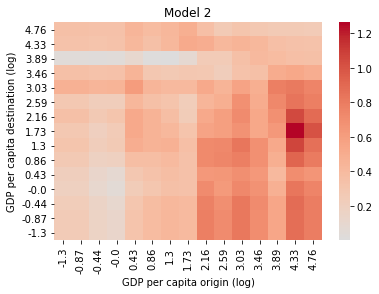

In [120]:
df4 = pd.DataFrame.from_dict(np.array([np.around(X_test[:, 0], decimals=2, out=None),
                                          np.around(X_test[:, 1], decimals=2, out=None),
                                          tau_4]).T)

df4.columns = ['X_value','Y_value','Z_value']

df4['Z_value'] = pd.to_numeric(df4['Z_value'])

df4 = df4.pivot('Y_value','X_value','Z_value')

df4.sort_index(level=0, ascending=False, inplace=True)

sns.heatmap(df4,
            cmap='coolwarm',
            center=0)

# Add title and labels to plot.
plt.title('Model 2')
plt.xlabel('GDP per capita origin (log)')
plt.ylabel('GDP per capita destination (log)')
plt.savefig("charts/heatmap_model_4.png")

## Comparison of propensity scores 

In [92]:
est3.summary(T=1)

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X0,-19.373,19.476,-0.995,0.32,-51.407,12.662
X1,-27.404,27.338,-1.002,0.316,-72.371,17.563
,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
cate_intercept,38.875,38.435,1.011,0.312,-24.345,102.096


Now we can have a look at the estimated effect:

Now we can plot a heatmap with the estimated effects, for a range of the variables used in the computation of the heterogenous effects

In [48]:
te_pred = est.effect(X_test)
lb, ub = est.effect_interval(X_test, alpha=0.01)

Now we can investigate the estimated effects. The model we used assumes a liner relationship between the variables used for the computation of the heterogenous effects and the outcome. We should be able to retrieve the numbers displayed above.

* by setting X to zero we find out the two intercepts
* by keeping constant the GDP per capita of the origin  and changing the one of the destination, we see the marginal 
* as above, but inverst origin and destination

In [49]:
# is an intercept estimated?
est.const_marginal_effect([[0, 0]])

array([[0.18394265]])

In [50]:
k = est.const_marginal_effect([[0, 1], [1, 1], [2, 1]])
k

array([[0.15855927],
       [0.20327184],
       [0.24798442]])

In [51]:
# marginal effect of the BIT (increase the GDP per capita or the origin)
print(k[1,0] - k[0,0])
print(k[2,0] - k[1,0])

0.044712574488742246
0.044712574488742274


Plot a heatmap with the effect for the different combinations of GDP per capita

In [52]:
df_bit = pd.DataFrame.from_dict(np.array([np.around(X_test[:, 0], decimals=2, out=None),
                                          np.around(X_test[:, 1], decimals=2, out=None),
                                          te_pred]).T)
df_bit.columns = ['X_value','Y_value','Z_value']
df_bit['Z_value'] = pd.to_numeric(df_bit['Z_value'])



In [53]:
df_bit_piv = df_bit.pivot('Y_value','X_value','Z_value')

In [54]:
df_bit_piv.sort_index(level=0, ascending=False, inplace=True)

Text(33.0, 0.5, 'GDP per capita destination (log)')

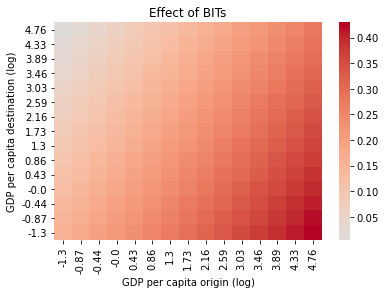

In [55]:
import seaborn as sns
sns.heatmap(df_bit_piv,cmap='coolwarm', center=0)
cmap="YlGnBu"

# Add title and labels to plot.
plt.title('Effect of BITs')
plt.xlabel('GDP per capita origin (log)')
plt.ylabel('GDP per capita destination (log)')


Now we can investigate a bit more in detail.

We can study the effects by making use of the **SHAP (SHapley Additive exPlanations)** library https://shap.readthedocs.io/en/latest/ 



In [56]:
import shap

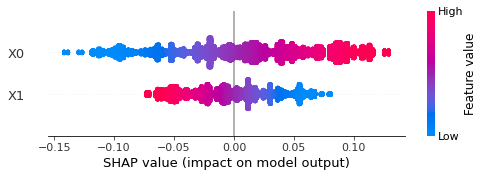

In [57]:
shap_values = est.shap_values(X)
shap.plots.beeswarm(shap_values['Y0']['T0_1'])

In [60]:

est.effect_inference(X_test).summary_frame(alpha=0.1, value=0, decimals=3)



,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
0,0.159,0.127,1.252,0.211,-0.050,0.367
1,0.148,0.118,1.248,0.212,-0.047,0.343
2,0.137,0.110,1.239,0.215,-0.045,0.318
3,0.126,0.103,1.224,0.221,-0.043,0.295
4,0.115,0.096,1.201,0.230,-0.042,0.272
...,...,...,...,...,...,...
220,0.320,0.070,4.546,0.000,0.204,0.436
221,0.309,0.076,4.049,0.000,0.183,0.434
222,0.298,0.083,3.586,0.000,0.161,0.435


In [59]:
lb_effect, ub_effect = est.const_marginal_effect_interval(X, alpha=.05)
pnt_coef = est.coef_
lb_coef, ub_coef = est.coef__interval(alpha=.05)

Population inference using sample

In [61]:
est.effect_inference(X_test).population_summary(alpha=0.1, value=0, decimals=3, tol=0.001)

In [62]:
# coefficients inference
est.coef__inference().summary_frame()

,point_estimate,stderr,zstat,pvalue,ci_lower,ci_upper
X,,,,,,
X0,0.045,0.021,2.168,0.030,0.011,0.079
X1,-0.025,0.024,-1.064,0.287,-0.065,0.014


Now we can visualize the effects

In [ ]:
point = est.const_marginal_effect(X)
lb, ub = est.const_marginal_effect_interval(X, alpha=0.05)

In [ ]:
#plot zero line
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
#plt.plot(X[:, 0], np.repeat(0,X[0]), '--') # zero line
plt.plot(X[:, 0], point, '--')
#plt.plot(X_test[:, 0], pred2, label='nonparamdml')
#plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X[:, 0], lb, ub, alpha=.4, label='Honest CI')
plt.legend()
plt.show()

### Binary outcome, one binary treatment 

Both y and t are binary in this case, therefore can use a random forest classifier for the two prediction tasks

In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestClassifier

est_dum = CausalForestDML(model_y=RandomForestClassifier(),
                          model_t=RandomForestClassifier())
est_dum.fit(y_dum,
            t_dum,
            X=X_dum,
            W=W_dum)

In [ ]:
est_dum.score_

In [ ]:
point = est_dum.const_marginal_effect(X_dum_test)
point.shape

In [ ]:
plt.hist(d['stock'].values)


In [ ]:
point

In [ ]:
# 95% confidence intervals for the hetero effects
lb, ub = est_dum.effect_interval(X_dum_test,
                                 T0=t0,
                                 T1=t1,
                                 alpha=0.05)

In [ ]:
#plot zero line
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_dum_test[:, 0], np.repeat(0,X_dum_test.shape[0]), '--') # zero line
plt.plot(X_dum_test[:, 0], point, '--')
#plt.plot(X_test[:, 0], pred2, label='nonparamdml')
#plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X_dum_test[:, 0], lb, ub, alpha=.4, label='Honest CI')
plt.legend()
plt.show()

### Continuous outcome, one binary treatment

In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import RandomForestClassifier

est_dum = CausalForestDML(model_y=RandomForestClassifier(),
                          model_t=RandomForestClassifier())
est_dum.fit(y_dum,
            t_dum,
            X=X_dum,
            W=W_dum)


In [ ]:
from econml.dml import CausalForestDML
from sklearn.ensemble import GradientBoostingRegressor

GB builds an additive model in a forward stage-wise fashion; it allows for the optimization of arbitrary differentiable loss functions. In each stage a regression tree is fit on the negative gradient of the given loss function.

In [ ]:
est = CausalForestDML(model_y=GradientBoostingRegressor(),
                     model_t=GradientBoostingRegressor())

In [ ]:
est.fit(y_val,
        t_val,
        X=X_val,
        W=W_val)

In [ ]:
est.score_

In [ ]:
point = est.const_marginal_effect(X_dum_test)
point.shape

In [ ]:
lb, ub = est.const_marginal_effect_interval(X_dum_test, alpha=.05)

In [ ]:
#plot zero line
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_dum_test[:, 0], np.repeat(0,X_dum_test.shape[0]), '--') # zero line
plt.plot(X_dum_test[:, 0], point, '-')
#plt.plot(X_test[:, 0], pred2, label='nonparamdml')
#plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X_dum_test[:, 0], lb, ub, alpha=.4, label='Honest CI')
plt.legend()
plt.show()

Try to modify the models for the treatment selection


In [ ]:
est = CausalForestDML(model_y=GradientBoostingRegressor(),
                     model_t=RandomForestClassifier())

In [ ]:
est.fit(y_val,
        t_val,
        X=X_val,
        W=W_val)

In [ ]:
point = est.const_marginal_effect(X_dum_test)
point.shape

In [ ]:
lb, ub = est.const_marginal_effect_interval(X_dum_test, alpha=.05)

In [ ]:
#plot zero line
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(X_dum_test[:, 0], np.repeat(0,X_dum_test.shape[0]), '--') # zero line
plt.plot(X_dum_test[:, 0], point, '-')
#plt.plot(X_test[:, 0], pred2, label='nonparamdml')
#plt.plot(X_test[:, 0], pred, label='forestdml (causal forest)')
plt.fill_between(X_dum_test[:, 0], lb, ub, alpha=.4, label='Honest CI')
plt.legend()
plt.show()

In [ ]:
est.score_

Let s try a linear effect

## Causal forest, Doubly Robust Machine Learning (ForestDRLearner)

In [ ]:
from econml.dr import ForestDRLearner
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
est = ForestDRLearner(model_regression=GradientBoostingRegressor(),
                      model_propensity=GradientBoostingClassifier())
est.fit(y, t, X=X, W=W)


In [ ]:
point = est.effect(X, T0=t0, T1=t1)
lb, ub = est.effect_interval(X, T0=t0, T1=t1, alpha=0.05)

In [ ]:
est.score_